This notebook is used to do a main model run with the UK disentangled

In [1]:
from epimodel import EpidemiologicalParameters, preprocess_data
from epimodel.pymc3_models.models import ComplexDifferentEffectsModel

import numpy as np
import pymc3 as pm

Set Theano Environmental Variables for Parallelisation


In [2]:
data = preprocess_data('../merged_data/data_final_nov.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Mask Wearing
Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [3]:
ep = EpidemiologicalParameters()

In [4]:
bd = ep.get_model_build_dict()

In [5]:
bd

{'gi_mean_mean': 5.06,
 'gi_mean_sd': 0.3265,
 'gi_sd_mean': 2.11,
 'gi_sd_sd': 0.5,
 'deaths_delay_mean_mean': 21.819649695284962,
 'deaths_delay_mean_sd': 1.0056755718977664,
 'deaths_delay_disp_mean': 14.26238141720708,
 'deaths_delay_disp_sd': 5.177442947725441,
 'cases_delay_mean_mean': 10.92830227448381,
 'cases_delay_mean_sd': 0.9387435298564465,
 'cases_delay_disp_mean': 5.406593726647138,
 'cases_delay_disp_sd': 0.2689502951493133}

In [6]:
with ComplexDifferentEffectsModel(data) as model:
    model.build_model(**bd)

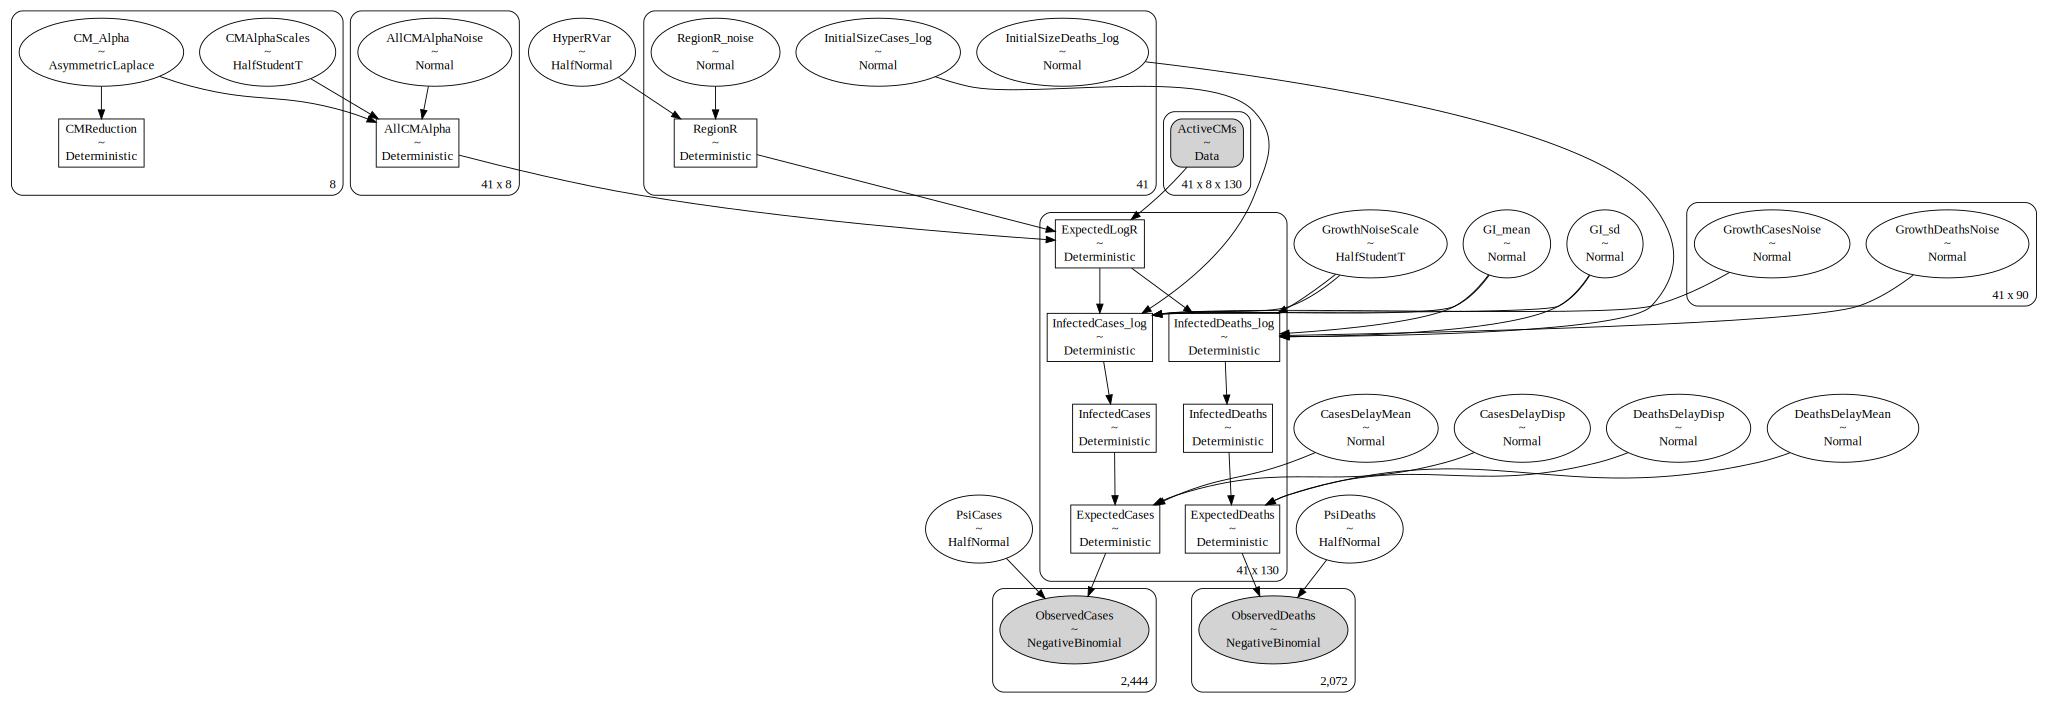

In [7]:
pm.model_to_graphviz(model)

In [8]:
with model:
    model.trace = pm.sample(2000, tune=500, cores=4, chains=4, max_treedepth=12, target_accept=0.96)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [DeathsDelayDisp, DeathsDelayMean, InitialSizeDeaths_log, CasesDelayDisp, CasesDelayMean, InitialSizeCases_log, PsiDeaths, PsiCases, GrowthDeathsNoise, GrowthCasesNoise, GrowthNoiseScale, GI_sd, GI_mean, RegionR_noise, HyperRVar, AllCMAlphaNoise, CMAlphaScales, CM_Alpha]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 39545 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
# save results in a pickle file
import pickle
pickle.dump(model.trace, open('traces/final_final_nov.pkl', 'wb'))

In [10]:
import arviz as az

In [ ]:
model.trace.varnames

array([[<AxesSubplot:title={'center':'GrowthNoiseScale'}>,
        <AxesSubplot:title={'center':'GrowthNoiseScale'}>]], dtype=object)

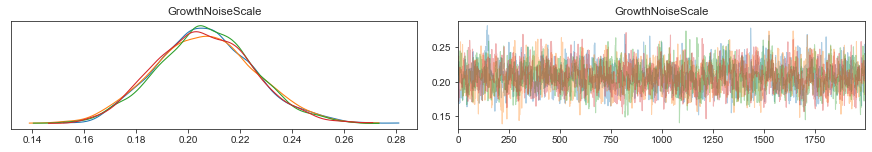

In [11]:
az.plot_trace(model.trace, var_names=['GrowthNoiseScale'])

In [12]:
ess = az.ess(model.trace)

In [13]:
rhat = az.rhat(model.trace)

In [14]:
def collate(stat):
    stat_all = []
    stat_nums = []
    for var in ["CMReduction", "GI_mean", "GI_sd", "GrowthCasesNoise", "GrowthDeathsNoise", "CasesDelayMean", "CasesDelayDisp",
                "InitialSizeDeaths_log", "InitialSizeCases_log", "DeathsDelayMean", "DeathsDelayDisp", "HyperRVar", "PsiCases",
                "PsiDeaths", "InfectedDeaths", "InfectedCases", "ExpectedDeaths", "ExpectedCases", "AllCMAlphaNoise", "CMAlphaScales"]:
        if stat[str(var)].size>1:
            stat_all.append(stat[str(var)].to_dataframe().to_numpy().flatten())
        else:
            stat_nums.append(float(stat[str(var)]))
    stat_all = np.concatenate(np.array(stat_all))
    stat_all = np.concatenate([stat_all, stat_nums])
#     stat_all[stat_all > 100] = 1
    return stat_all

In [15]:
ess

<xarray.Dataset>
Dimensions:                      (AllCMAlphaNoise_dim_0: 41, AllCMAlphaNoise_dim_1: 8, AllCMAlpha_dim_0: 41, AllCMAlpha_dim_1: 8, CMAlphaScales_dim_0: 8, CMReduction_dim_0: 8, CM_Alpha_dim_0: 8, ExpectedCases_dim_0: 41, ExpectedCases_dim_1: 130, ExpectedDeaths_dim_0: 41, ExpectedDeaths_dim_1: 130, ExpectedLogR_dim_0: 41, ExpectedLogR_dim_1: 130, GrowthCasesNoise_dim_0: 41, GrowthCasesNoise_dim_1: 90, GrowthDeathsNoise_dim_0: 41, GrowthDeathsNoise_dim_1: 90, InfectedCases_dim_0: 41, InfectedCases_dim_1: 130, InfectedCases_log_dim_0: 41, InfectedCases_log_dim_1: 130, InfectedDeaths_dim_0: 41, InfectedDeaths_dim_1: 130, InfectedDeaths_log_dim_0: 41, InfectedDeaths_log_dim_1: 130, InitialSizeCases_log_dim_0: 41, InitialSizeDeaths_log_dim_0: 41, RegionR_dim_0: 41, RegionR_noise_dim_0: 41)
Coordinates:
  * CM_Alpha_dim_0               (CM_Alpha_dim_0) int64 0 1 2 3 4 5 6 7
  * AllCMAlphaNoise_dim_0        (AllCMAlphaNoise_dim_0) int64 0 1 2 ... 39 40
  * AllCMAlphaNoise_dim_1        (AllCMAlphaNoise_dim_1) int64 0 1 2 3 4 5 6 7
  * RegionR_noise_dim_0          (RegionR_noise_dim_0) int64 0 1 2 ... 38 39 40
  * GrowthCasesNoise_dim_0       (GrowthCasesNoise_dim_0) int64 0 1 2 ... 39 40
  * GrowthCasesNoise_dim_1       (GrowthCasesNoise_dim_1) int64 0 1 2 ... 88 89
  * GrowthDeathsNoise_dim_0      (GrowthDeathsNoise_dim_0) int64 0 1 2 ... 39 40
  * GrowthDeathsNoise_dim_1      (GrowthDeathsNoise_dim_1) int64 0 1 2 ... 88 89
  * InitialSizeCases_log_dim_0   (InitialSizeCases_log_dim_0) int64 0 1 ... 40
  * InitialSizeDeaths_log_dim_0  (InitialSizeDeaths_log_dim_0) int64 0 1 ... 40
  * CMReduction_dim_0            (CMReduction_dim_0) int64 0 1 2 3 4 5 6 7
  * CMAlphaScales_dim_0          (CMAlphaScales_dim_0) int64 0 1 2 3 4 5 6 7
  * AllCMAlpha_dim_0             (AllCMAlpha_dim_0) int64 0 1 2 3 ... 38 39 40
  * AllCMAlpha_dim_1             (AllCMAlpha_dim_1) int64 0 1 2 3 4 5 6 7
  * RegionR_dim_0                (RegionR_dim_0) int64 0 1 2 3 4 ... 37 38 39 40
  * ExpectedLogR_dim_0           (ExpectedLogR_dim_0) int64 0 1 2 3 ... 38 39 40
  * ExpectedLogR_dim_1           (ExpectedLogR_dim_1) int64 0 1 2 ... 128 129
  * InfectedCases_log_dim_0      (InfectedCases_log_dim_0) int64 0 1 2 ... 39 40
  * InfectedCases_log_dim_1      (InfectedCases_log_dim_1) int64 0 1 ... 128 129
  * InfectedCases_dim_0          (InfectedCases_dim_0) int64 0 1 2 ... 38 39 40
  * InfectedCases_dim_1          (InfectedCases_dim_1) int64 0 1 2 ... 128 129
  * ExpectedCases_dim_0          (ExpectedCases_dim_0) int64 0 1 2 ... 38 39 40
  * ExpectedCases_dim_1          (ExpectedCases_dim_1) int64 0 1 2 ... 128 129
  * InfectedDeaths_log_dim_0     (InfectedDeaths_log_dim_0) int64 0 1 ... 39 40
  * InfectedDeaths_log_dim_1     (InfectedDeaths_log_dim_1) int64 0 1 ... 129
  * InfectedDeaths_dim_0         (InfectedDeaths_dim_0) int64 0 1 2 ... 38 39 40
  * InfectedDeaths_dim_1         (InfectedDeaths_dim_1) int64 0 1 2 ... 128 129
  * ExpectedDeaths_dim_0         (ExpectedDeaths_dim_0) int64 0 1 2 ... 38 39 40
  * ExpectedDeaths_dim_1         (ExpectedDeaths_dim_1) int64 0 1 2 ... 128 129
Data variables:
    CM_Alpha                     (CM_Alpha_dim_0) float64 2.825e+03 ... 2.067...
    AllCMAlphaNoise              (AllCMAlphaNoise_dim_0, AllCMAlphaNoise_dim_1) float64 ...
    RegionR_noise                (RegionR_noise_dim_0) float64 3.864e+03 ... ...
    GI_mean                      float64 2.049e+03
    GI_sd                        float64 2.146e+03
    GrowthCasesNoise             (GrowthCasesNoise_dim_0, GrowthCasesNoise_dim_1) float64 ...
    GrowthDeathsNoise            (GrowthDeathsNoise_dim_0, GrowthDeathsNoise_dim_1) float64 ...
    InitialSizeCases_log         (InitialSizeCases_log_dim_0) float64 2.52e+0...
    CasesDelayMean               float64 3.927e+03
    CasesDelayDisp               float64 9.579e+03
    InitialSizeDeaths_log        (InitialSizeDeaths_log_dim_0) float64 2.65e+...
    DeathsDelayMean              float64 4.249e+03
  

<ipython-input-14-ce0aadee7bc1>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  stat_all = np.concatenate(np.array(stat_all))


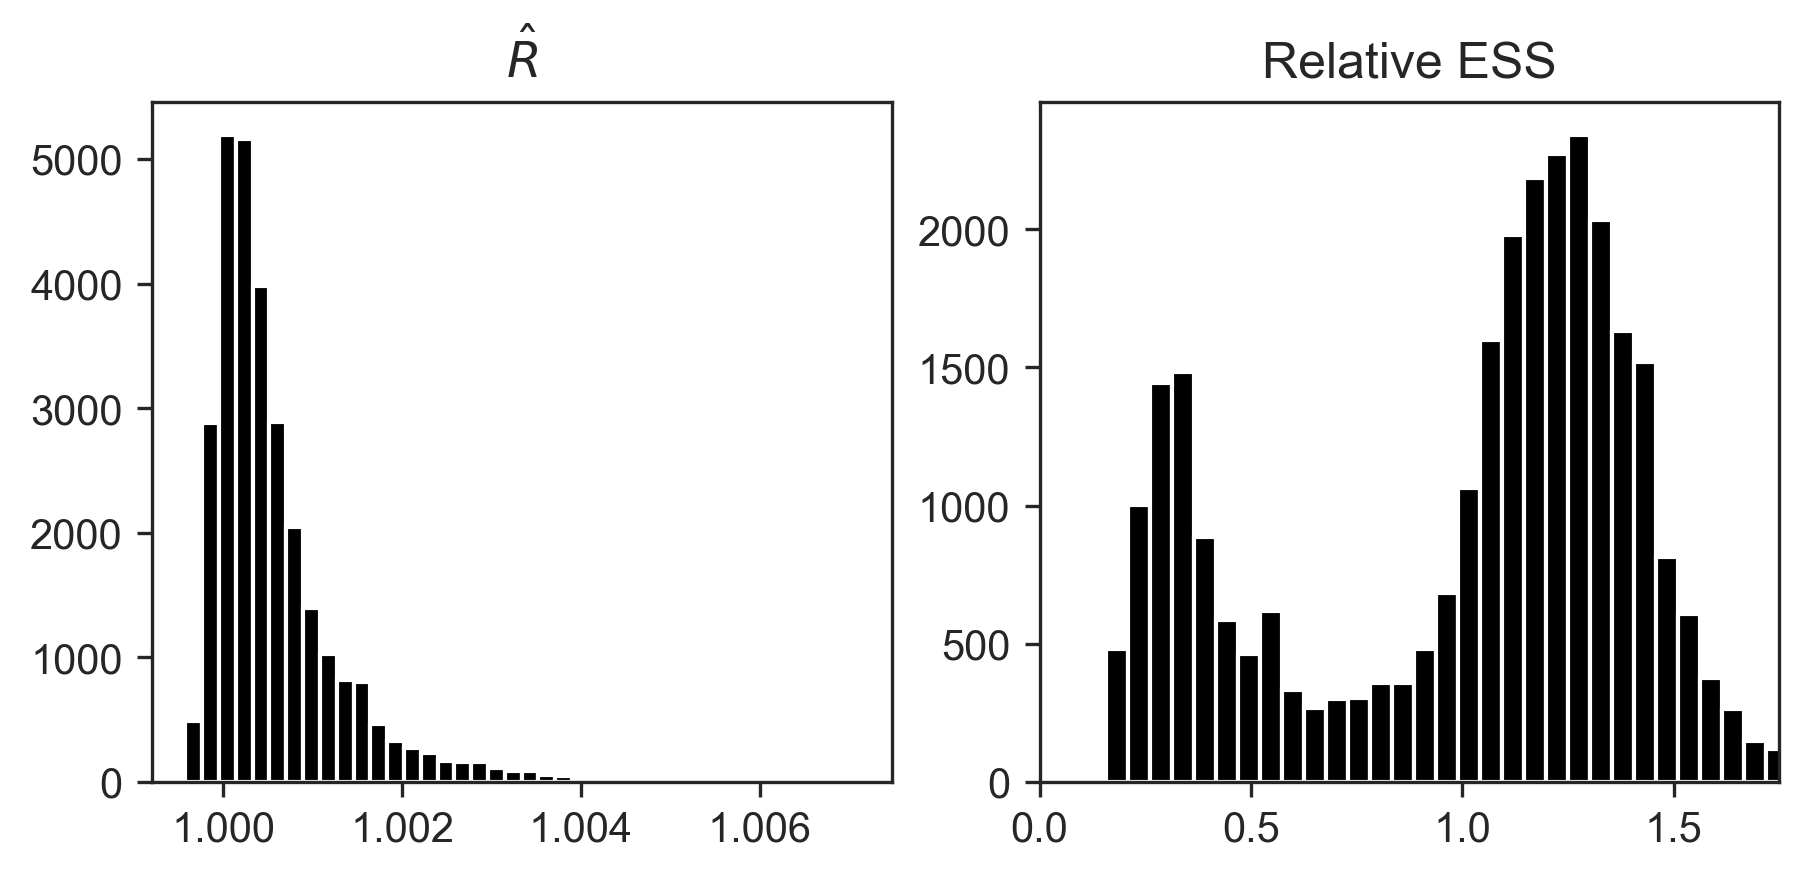

In [17]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(7, 3), dpi=300)
plt.subplot(121)
plt.hist(collate(rhat), bins=40, color='k')
plt.title("$\hat{R}$", fontsize=12)

plt.subplot(122)
plt.hist(collate(ess)/8000, bins=40, color='k')
plt.xlim([0, 1.75])
plt.title("Relative ESS", fontsize=12)
plt.savefig(f"figs/main/FigureMCMCStats.pdf", bbox_inches='tight')

In [ ]:
# save results in a pickle file
import pickle
pickle.dump(model.trace, open('traces/final_nov.pkl', 'wb'))

In [ ]:
# csv file for mitigation calculator
cm_red = np.zeros((8000, 8))
cm_red[:, :] = model.trace.CMReduction[:, [0, 1, 2, 3, 4, 5, 6, 8]]

# combine schools and unis into one NPI
cm_red[:, 6] = cm_red[:, 6] * model.trace.CMReduction[:, 7]

np.savetxt('traces.txt', cm_red, delimiter=',', header='Mask Wearing, Gatherings<1000, Gatherings<100, Gatherings<10, Some Business, Most Business, School+Uni, StayHome' )